Lesson 6 - Applied Regression Modeling - Multiple Linear Regression

Multiple Linear Regression:  We next consider regression models with more than one predictor variable.  Such models are referred to as mulitple linear regression.

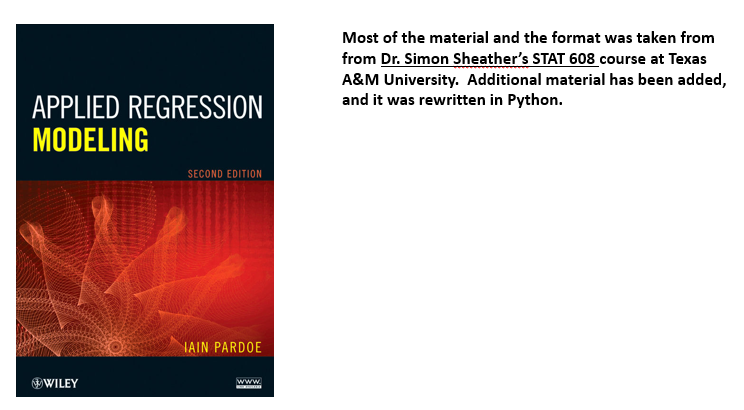

<b>ATTRIBUTION/ CITATION:</b> Most of this material including the course outline was taken from Dr. Simon Sheather's STAT 608 course at Texas A&M University. However, it uses additional examples and was adopted for use with Python. In addition, much of the course material used the textbook Applied Regression Modeling by Iain Pardoe. 

# Cast Study:  Modeling 2015 Domestic Box Office Gross
Question:  To what extent can domestic box office grosses (i.e., Total Gross) be modeled from a
number of predictors including gross box office receipts for the opening weekend?
Source: https://www.boxofficemojo.com/year/2015/

- We wish to develop a model for Domestic Box Office Gross (Total gross)
- Available predictor variables:
    - Widest release (Maximum number of theaters at which the film was screened. Theaters refers to the number of locations where a movie is playing, but it does not reflect the number of screens. One theater location, for example, may play a movie on several screens. )
    - Opening gross (Gross box office receipts for the opening weekend)
    - Opening theaters
    - Days In Release
    - Studio

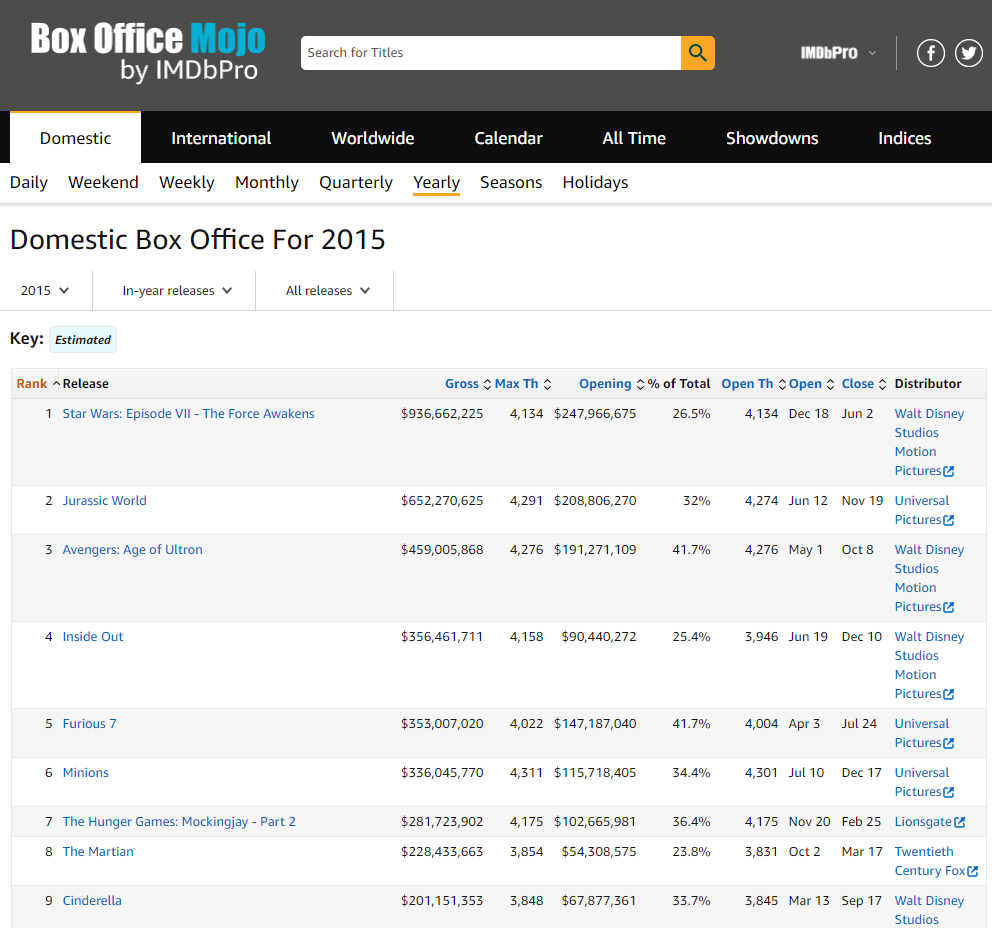

In [56]:
import pandas as pd
import numpy as np
import re
import os
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import urllib.request
from tqdm.notebook import tqdm_notebook as tqdm


In [57]:
# dataframe settings

pd.options.display.max_rows = 100        #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 100     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)        #Increases the width of the columns to display 100 characters at the same time.

In [58]:
def get_soup(url):
    
    parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
    
    return soup

In [59]:
def find_movie_title(soup):
    
    s = str(soup)
    movie_title = re.findall(r'<title dir="ltr">(.*)</title>', s)[0]
    movie_title = re.sub(' - Box Office Mojo','', movie_title)

    return movie_title



In [60]:
def find_widest_release(soup):
    
    s = str(soup)
    widest_release = re.findall(r'Widest Release</span><span>(.*) theaters</span>', s)[0]  
    widest_release = widest_release.strip(' ,')
    
    return int(widest_release)

In [61]:
def find_opening_data(soup):
    
    s = str(soup)
    opening_data =  re.findall(r'Opening</span><span><span class="money">(.*)\n', s)[0]
    opening_data = opening_data.split('</span><br/>')
    opening_gross = int(opening_data[0].strip('$').replace(',',''))
    opening_theaters = int(opening_data[1].strip('$').replace(',',''))
    
    return (opening_gross, opening_theaters)

In [62]:
def find_days_in_release(soup):
    
    s = str(soup)
    days_in_release = re.search(r'In Release</span><span>(.*?)</span></div><div class="a-section a-spacing-none"><span>', s).group(1)
    #days_in_release = int(days_in_release.split('/')[0].replace(' days',''))
    days_in_release = days_in_release[0:3]
    
    return days_in_release

In [63]:
def find_dates(soup):
    s = str(soup)
    dates = re.findall(r'<a class="a-link-normal" href="/date/(.*)/?ref_=bo_rl_rl">', s)
    opening_date = dates[0].strip('/?')
    closing_date = dates[1].strip('/?')

    return (opening_date, closing_date)

In [64]:
def get_initial_df(url):
    
    df = pd.read_html(url)[0]
    df['Movie Title'] = df['Release']
    df['Studio'] = df['Distributor']
    df['Total Gross'] = df['Gross'].replace({'\$': '', ',': ''}, regex=True)
    df['Widest Release'] = df['Max Th']
    df['Opening Gross'] = df['Opening'].replace({'\$': '', ',': ''}, regex=True)
    df['Opening Theaters'] = df['Open Th']
    df = df[['Movie Title','Studio','Total Gross','Widest Release','Opening Gross','Opening Theaters']]
    
    return df

In [65]:
def get_days_dates(url):
    
    pbar = tqdm(total=151) # display progress...
    
    links = [] 
    movie_titles_list = []
    days_list = []
    opening_dates_list = []
    closing_dates_list = []

    soup = get_soup(url)

    #print('Getting Links')

    for link in soup.find_all('a', href=True):
        links.append(link['href'])

    links = [link for link in links if str('/release/') in link]
    links = ['https://www.boxofficemojo.com/'+link for link in links]
    #print('Getting Movie Titles and Dates')

    for url in links:

        soup = get_soup(url)
        title = find_movie_title(soup)
        days = find_days_in_release(soup)
#        dates = find_dates(soup)
#         opening_date = dates[0]
#         closing_date = dates[1]

        movie_titles_list.append(title)
        days_list.append(days)
#         opening_dates_list.append(opening_date)
#         closing_dates_list.append(closing_date)
        # Nudge progress bar
        pbar.update()
        #print(title, days)

    days_df = pd.DataFrame()
    days_df['Movie Title'] = movie_titles_list
    days_df['Days In Release'] = days_list
#     days_df['Opening Date'] = opening_dates_list
#     days_df['Closing Date'] = closing_dates_list
    
    return days_df


In [66]:
def get_data(url):
    url = url
    df1 = get_initial_df(url)
    df2 = get_days_dates(url)
    df = df1.merge(df2, how = 'inner', on = 'Movie Title')
    
    print(df1.info())
    print(df2.info())
    print(df.info())
    #df['Days In Release'] = df['Days In Release'].str[:3]
    df.to_pickle('./US Box Office 2015.pkl')

    return df

# Get the data

In [67]:
url = 'https://www.boxofficemojo.com/year/2015/?grossesOption=totalGrosses'

if os.path.exists('./US Box Office 2015.pkl'):
    data = pd.read_pickle('./US Box Office 2015.pkl')
    print("Yay! It's there!")

else:
    data = get_data(url)

print('Length of the dataset is ', len(data))



Yay! It's there!
Length of the dataset is  662


# Examine the data and make sure it's in the right format

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662 entries, 0 to 661
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Movie Title       662 non-null    object
 1   Studio            662 non-null    object
 2   Total Gross       662 non-null    object
 3   Widest Release    662 non-null    object
 4   Opening Gross     662 non-null    object
 5   Opening Theaters  662 non-null    object
 6   Days In Release   662 non-null    object
dtypes: object(7)
memory usage: 41.4+ KB


In [72]:
data.head(10)

Movie Title  \
0  Star Wars: Episode VII - The Force Awakens   
1                              Jurassic World   
2                     Avengers: Age of Ultron   
3                                  Inside Out   
4                                   Furious 7   
5                                     Minions   
6       The Hunger Games: Mockingjay - Part 2   
7                                 The Martian   
8                                  Cinderella   
9                                     Spectre   

                                Studio Total Gross Widest Release  \
0  Walt Disney Studios Motion Pictures   936662225           4134   
1                   Universal Pictures   652270625           4291   
2  Walt Disney Studios Motion Pictures   459005868           4276   
3  Walt Disney Studios Motion Pictures   356461711           4158   
4                   Universal Pictures   353007020           4022   
5                   Universal Pictures   336045770           4311   
6                            Lionsgate   281723902           4175   
7                Twentieth Century Fox   228433663           3854   
8  Walt Disney Studios Motion Pictures   201151353           3848   
9    Sony Pictures Entertainment (SPE)   200074609           3929   

  Opening Gross Opening Theaters Days In Release  
0     247966675             4134             380  
1     208806270             4274             210  
2     191271109             4276             245  
3      90440272             3946             203  
4     147187040             4004             273  
5     115718405             4301             182  
6     102665981             4175             408  
7      54308575             3831             457  
8      67877361             3845             294  
9      70403148             3929             422

In [14]:
data.tail(20)

Movie Title  \
642  The Other Man: F.W. de Klerk and the End of Apartheid   
643                                            Dark Forest   
644                                      The Looking Glass   
645                                                  Drown   
646                                              Cut Snake   
647                                                Forever   
648                                  Stations of the Cross   
649                                          Making Rounds   
650                                 3 Nights in the Desert   
651                                             Skin Trade   
652                                                El nino   
653                                              Childless   
654                                            They Are We   
655                                  Le talent de mes amis   
656                                              Big Muddy   
657                                    [REC] 4: Apocalypse   
658                                        United Passions   
659                                   The Chambermaid Lynn   
660                                                   Lou!   
661                                         Paranoid Girls   

                 Studio Total Gross Widest Release Opening Gross  \
642           First Run        1747              1          1153   
643     Zell-Koj Studio        1739              1          1739   
644           First Run        1711              2           107   
645    Strand Releasing        1631              1           860   
646      Monterey Media        1625              3             -   
647      Monterey Media        1598              1             -   
648       Film Movement        1505              1           688   
649           First Run        1484              1          1056   
650      Monterey Media        1297              2           234   
651   Magnolia Pictures        1242              1           162   
652       Distrib Films        1237              1           245   
653      Monterey Media        1036              1           732   
654        Icarus Films         900              1           590   
655       Distrib Films         889              1           587   
656      Monterey Media         881              3           147   
657   Magnolia Pictures         837              5           708   
658  Screen Media Films         607             10           607   
659       Film Movement         315              1             -   
660       Distrib Films         287              1            88   
661                   -          78              1            54   

    Opening Theaters Days In Release  
642                1             329  
643                1             133  
644                2             77   
645                1             133  
646                -             93   
647                -             112  
648                1             175  
649                1             63   
650                2             329  
651                1             238  
652                1             259  
653                1             231  
654                1             189  
655                1             28   
656                2             343  
657                5             364  
658               10             210  
659                -             217  
660                1             252  
661                1             56

### fix dashes in the data set

In [73]:
data = data.loc[data['Movie Title'] != '-']
data = data.loc[data['Studio'] != '-']
data = data.loc[data['Total Gross'] != '-']
data = data.loc[data['Widest Release'] != '-']
data = data.loc[data['Opening Gross'] != '-']
data = data.loc[data['Opening Theaters'] != '-']
data = data.loc[data['Days In Release'] != '-']

In [74]:
data.tail(20)

Movie Title  \
638                                               Anita Ho   
639             The Lady in the Car with Glasses and a Gun   
640                                  Me You and Five Bucks   
641                                           Sneakerheadz   
642  The Other Man: F.W. de Klerk and the End of Apartheid   
643                                            Dark Forest   
644                                      The Looking Glass   
645                                                  Drown   
648                                  Stations of the Cross   
649                                          Making Rounds   
650                                 3 Nights in the Desert   
651                                             Skin Trade   
652                                                El nino   
653                                              Childless   
654                                            They Are We   
655                                  Le talent de mes amis   
656                                              Big Muddy   
657                                    [REC] 4: Apocalypse   
658                                        United Passions   
660                                                   Lou!   

                 Studio Total Gross Widest Release Opening Gross  \
638    Indican Pictures        2250              1          2250   
639   Magnolia Pictures        2167              2           297   
640    Indican Pictures        2105              2           862   
641    Submarine Deluxe        1903              3          1903   
642           First Run        1747              1          1153   
643     Zell-Koj Studio        1739              1          1739   
644           First Run        1711              2           107   
645    Strand Releasing        1631              1           860   
648       Film Movement        1505              1           688   
649           First Run        1484              1          1056   
650      Monterey Media        1297              2           234   
651   Magnolia Pictures        1242              1           162   
652       Distrib Films        1237              1           245   
653      Monterey Media        1036              1           732   
654        Icarus Films         900              1           590   
655       Distrib Films         889              1           587   
656      Monterey Media         881              3           147   
657   Magnolia Pictures         837              5           708   
658  Screen Media Films         607             10           607   
660       Distrib Films         287              1            88   

    Opening Theaters Days In Release  
638                1             308  
639                2             380  
640                2             98   
641                3             147  
642                1             329  
643                1             133  
644                2             77   
645                1             133  
648                1             175  
649                1             63   
650                2             329  
651                1             238  
652                1             259  
653                1             231  
654                1             189  
655                1             28   
656                2             343  
657                5             364  
658               10             210  
660                1             252

### convert the columns to number columns

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 660
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Movie Title       560 non-null    object
 1   Studio            560 non-null    object
 2   Total Gross       560 non-null    object
 3   Widest Release    560 non-null    object
 4   Opening Gross     560 non-null    object
 5   Opening Theaters  560 non-null    object
 6   Days In Release   560 non-null    object
dtypes: object(7)
memory usage: 35.0+ KB


In [76]:
number_columns = ['Total Gross','Widest Release','Opening Gross','Opening Theaters','Days In Release']
for col in number_columns:
    data[col] = data[col].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 660
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Movie Title       560 non-null    object
 1   Studio            560 non-null    object
 2   Total Gross       560 non-null    int32 
 3   Widest Release    560 non-null    int32 
 4   Opening Gross     560 non-null    int32 
 5   Opening Theaters  560 non-null    int32 
 6   Days In Release   560 non-null    int32 
dtypes: int32(5), object(2)
memory usage: 24.1+ KB


# Success!

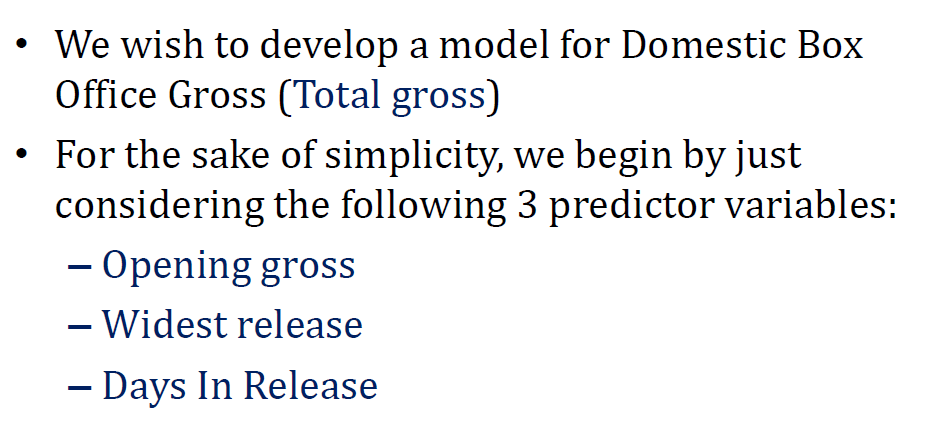

# Select the relevant columns

In [77]:
df = data.copy()
selected_columns = ['Total Gross','Opening Gross','Widest Release','Days In Release']
df = df[selected_columns]
df.head()

Total Gross  Opening Gross  Widest Release  Days In Release
0    936662225      247966675            4134              380
1    652270625      208806270            4291              210
2    459005868      191271109            4276              245
3    356461711       90440272            4158              203
4    353007020      147187040            4022              273

# Scatterplot Matrix: We always begin by plotting Y against each predictor (bottom row of plots) and each of the predictors against each other (top rows of plots) using a 

### Scatterplot Matrix method 1 with Pandas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000166B3E0A888>,
      dtype=object)

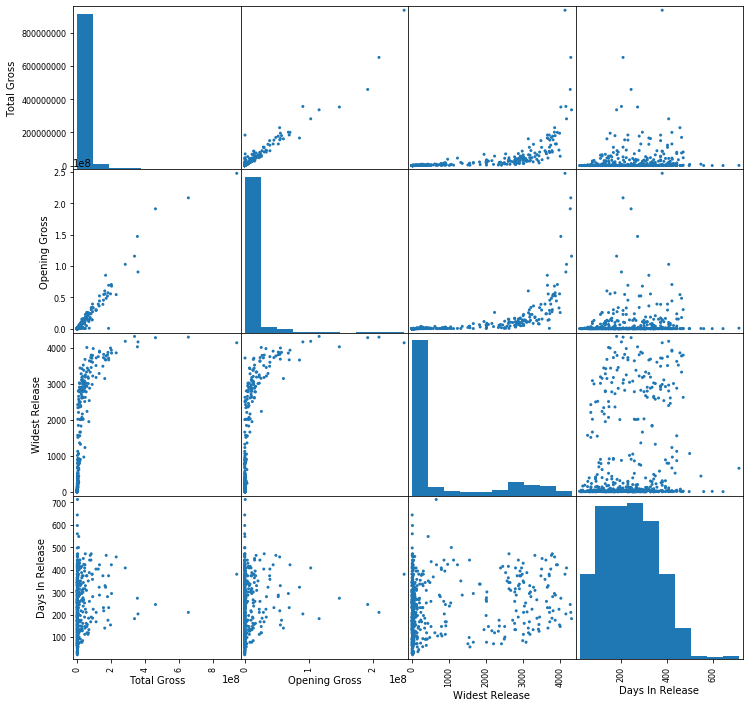

In [79]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha = 1, figsize = (12, 12))

### Scatterplot Matrix method 2 with Seaborn

<Figure size 504x504 with 0 Axes>

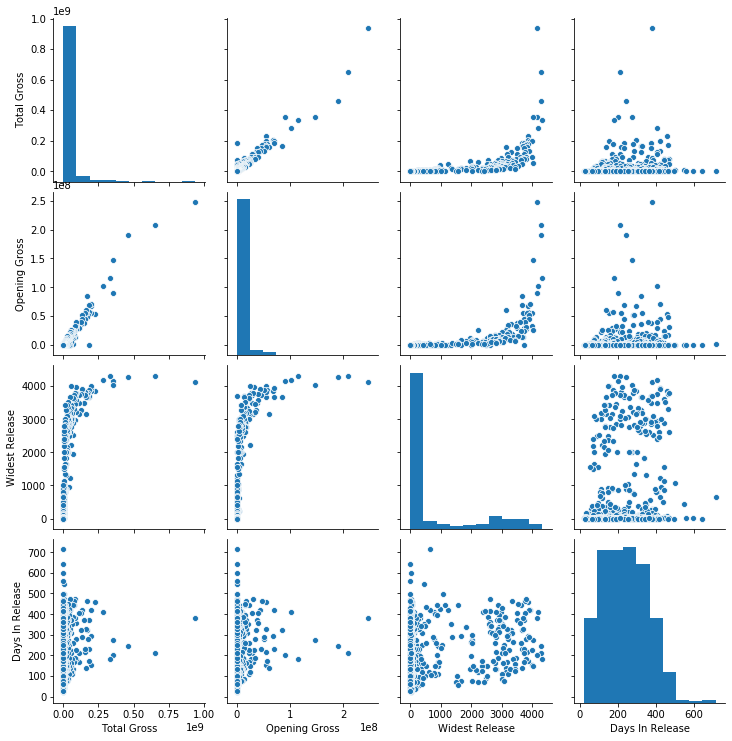

In [80]:
import seaborn as sns
plt.figure(figsize = (7,7))
sns.pairplot(df)

## CONCLUSIONS:  The relationship between Total Gross and the 3 predictor variables appears to not be linear

# Log Transform:  Since the relationship between Total Gross and the 3 predictor variables appears to not be linear, we will log transform each variable

### use 'select_dtypes()' to obtain the numerical columns in the pandas dataframe
- np.number or 'number'
- object
- np.datetime64, 'datetime' or 'datetime64'
- np.timedelta64, 'timedelta' or 'timedelta64'
- 'category'
- 'datetimetz' (new in 0.20.0) or 'datetime64[ns, tz]'

In [82]:
df.select_dtypes('number')

Total Gross  Opening Gross  Widest Release  Days In Release
0      936662225      247966675            4134              380
1      652270625      208806270            4291              210
2      459005868      191271109            4276              245
3      356461711       90440272            4158              203
4      353007020      147187040            4022              273
..           ...            ...             ...              ...
655          889            587               1               28
656          881            147               3              343
657          837            708               5              364
658          607            607              10              210
660          287             88               1              252

[560 rows x 4 columns]

### Log transform the numeric columns using np.log1p and .select_dtypes(int)

In [83]:
for col in df.select_dtypes(int).columns.to_list():
    log_name = 'Log['+col+']'
    df[log_name] = np.log1p(df[col])
df.head()

Total Gross  Opening Gross  Widest Release  Days In Release  \
0    936662225      247966675            4134              380   
1    652270625      208806270            4291              210   
2    459005868      191271109            4276              245   
3    356461711       90440272            4158              203   
4    353007020      147187040            4022              273   

   Log[Total Gross]  Log[Opening Gross]  Log[Widest Release]  \
0         20.657833           19.328805             8.327243   
1         20.295970           19.156917             8.364508   
2         19.944574           19.069202             8.361007   
3         19.691737           18.320200             8.333030   
4         19.681999           18.807215             8.299783   

   Log[Days In Release]  
0              5.942799  
1              5.351858  
2              5.505332  
3              5.318120  
4              5.613128

### Plot the scatterplot matrix of the LOG values using Pandas function scatter_matrix 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000166B5357048>,
      dtype=object)

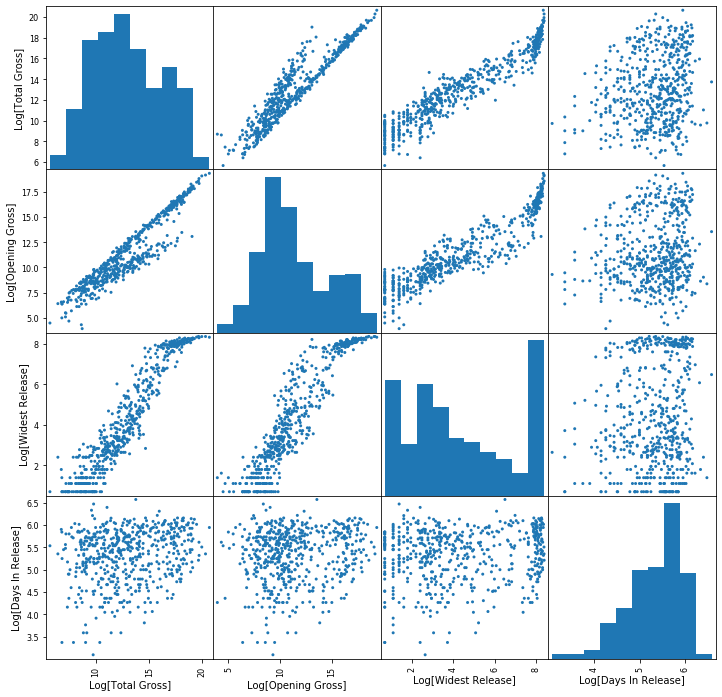

In [84]:
scatter_matrix(df[[col for col in df.columns.to_list() if 'Log'in col]], alpha = 1, figsize = (12, 12))

# What is Multiple Linear Regression
Multiple linear regression (MLR), also known simply as multiple regression, is a statistical technique that uses several explanatory variables to predict the outcome of a response variable. Multiple regression is an extension of linear (OLS) regression that uses just one explanatory variable.

https://www.investopedia.com/terms/m/mlr.asp

## Formula for calculating multiple linear regression

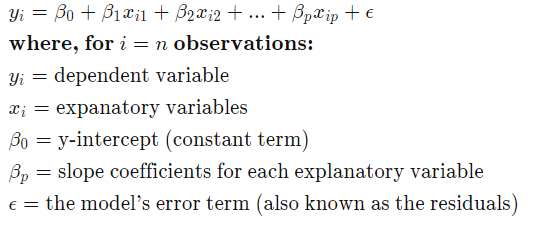

## Visualization 
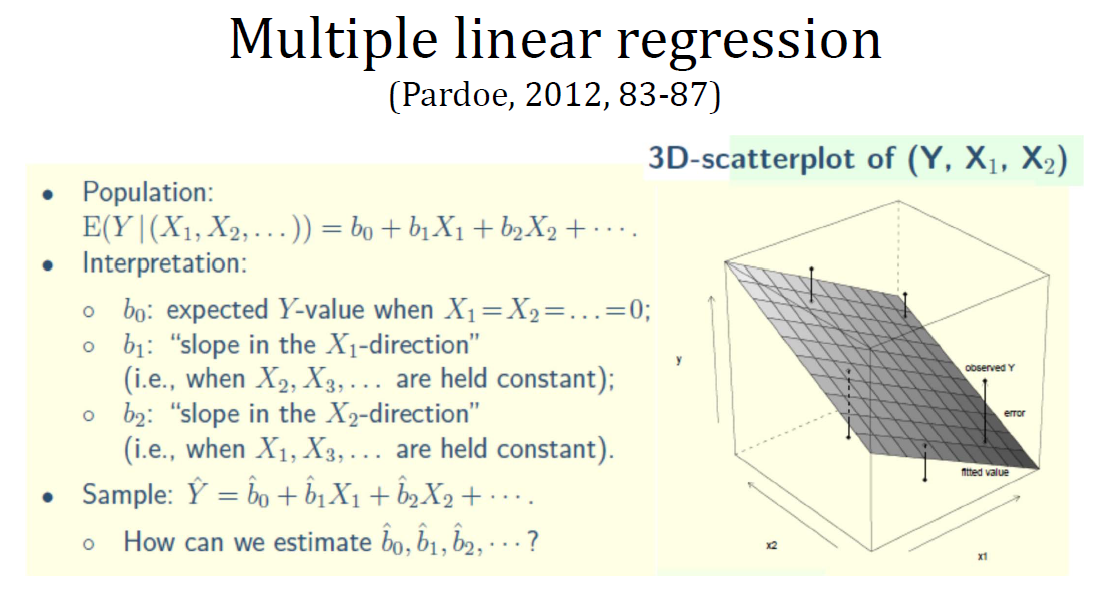

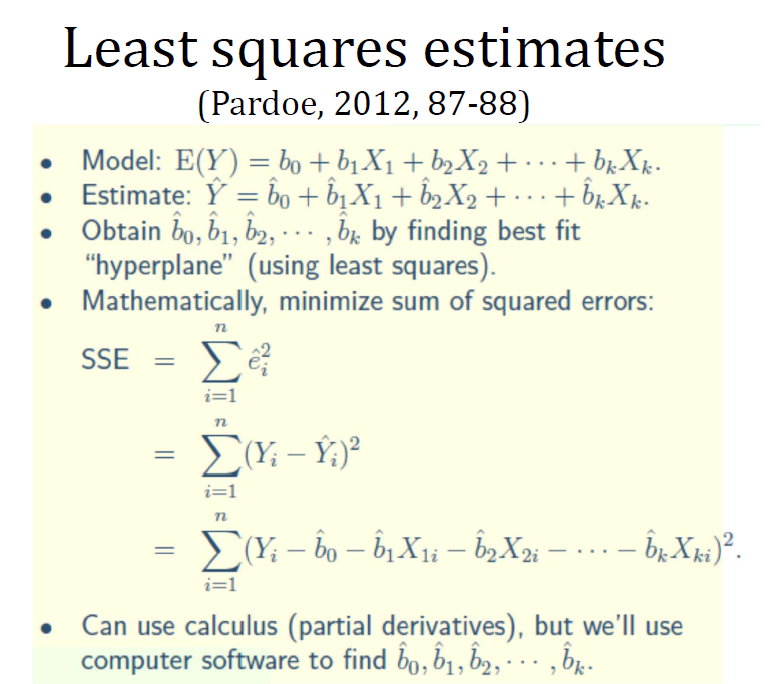

### import the module

In [85]:
import statsmodels.api as sm                    

### target Column 'y'

In [86]:
y = df['Log[Total Gross]']
y

0      20.657833
1      20.295970
2      19.944574
3      19.691737
4      19.681999
         ...    
655     6.791221
656     6.782192
657     6.731018
658     6.410175
660     5.662960
Name: Log[Total Gross], Length: 560, dtype: float64

### Predictor Columns 'X'
Using a capital letter X denotes a matrix while lower case x denotes a vector or column vector

In [87]:
X = df[[col for col in df.columns.to_list() if (('Log'in col)&('Total Gross'not in col))]]
X

Log[Opening Gross]  Log[Widest Release]  Log[Days In Release]
0             19.328805             8.327243              5.942799
1             19.156917             8.364508              5.351858
2             19.069202             8.361007              5.505332
3             18.320200             8.333030              5.318120
4             18.807215             8.299783              5.613128
..                  ...                  ...                   ...
655            6.376727             0.693147              3.367296
656            4.997212             1.386294              5.840642
657            6.563856             1.791759              5.899897
658            6.410175             2.397895              5.351858
660            4.488636             0.693147              5.533389

[560 rows x 3 columns]

### add a constant

In [88]:
X = sm.add_constant(X) 

### assign the model type

In [90]:
ols_model = sm.OLS(y, X)

### fit the coefficients in the model

In [91]:
fitted = ols_model.fit()

### make predictions

In [92]:
df['Log[Total Gross] Predicted'] = fitted.predict(X)

### get model diagnostic data

In [93]:
df['residuals'] = df['Log[Total Gross]'] - df['Log[Total Gross] Predicted'] # residuals
influence                   = fitted.get_influence()                        # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external          # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                   # cook's distance

### print the model summary

In [94]:
summary = fitted.summary() 
print(summary)

                            OLS Regression Results                            
Dep. Variable:       Log[Total Gross]   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2547.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:43:02   Log-Likelihood:                -706.80
No. Observations:                 560   AIC:                             1422.
Df Residuals:                     556   BIC:                             1439.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9770 

### predicted vs actual plot

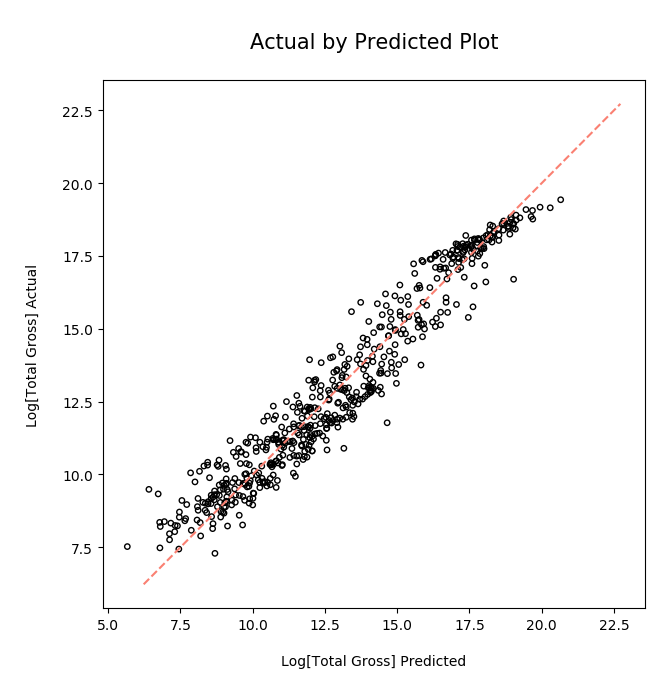

In [95]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (7,7), dpi = 100)

max_limits = max(max(df['Log[Total Gross]']),max(df['Log[Total Gross] Predicted']))*1.10
min_limits = min(min(df['Log[Total Gross]']),min(df['Log[Total Gross] Predicted']))*1.10
prediction_line = [min_limits, max_limits]
        
ax.set_title('\nActual by Predicted Plot\n', fontsize = 15)
ax.set_xlabel('\nLog[Total Gross] Predicted\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross] Actual\n', fontsize = 10)
ax.scatter(df['Log[Total Gross]'], df['Log[Total Gross] Predicted'], facecolors='none', edgecolors='black', linewidth = 1, s = 15)
ax.plot(prediction_line,prediction_line, color = 'salmon', linestyle = '--', label = 'Prediction Line')
plt.show()

### residual by predicted plot

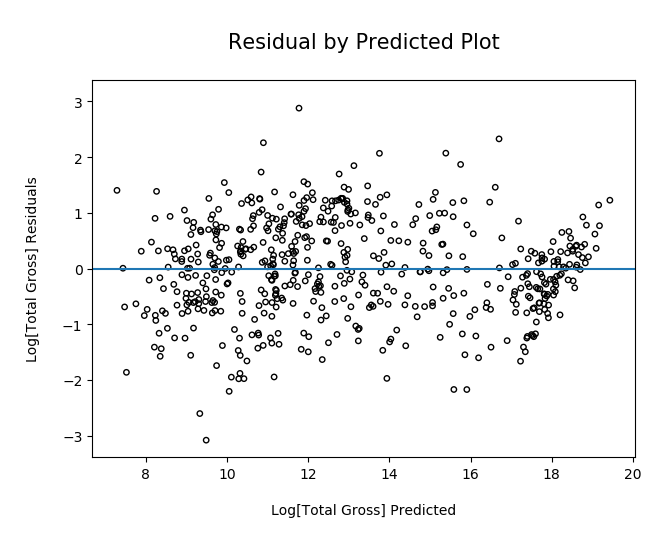

In [96]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)

max_limits = max(abs(min(df['residuals'])),abs(max(df['residuals'])))*1.10
        
ax.set_title('\nResidual by Predicted Plot\n', fontsize = 15)
ax.set_xlabel('\nLog[Total Gross] Predicted\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross] Residuals\n', fontsize = 10)
ax.scatter(df['Log[Total Gross] Predicted'], df['residuals'], facecolors='none', edgecolors='black', linewidth = 1, s = 15)
ax.set_ylim(-max_limits, max_limits)
ax.axhline(y=0)
plt.show()

## CONCLUSION: It's not too bad. We will be talking about VIF's later on... but for now this is not too bad (not perfect). Each of the predictors is statistically significant. 

### Further Examine (STATISTICS BACK IN THE OLDEN DAYS): Let's say we want to look at the relationship between Log[Opening Gross] and Log[Total Gross]. The t-statistic is 14.467, and the p-value is very very small!  Testing the Null Hypothesis that b1 = 0, and the Alternative Hypothesis that b1 > 0.  Thus, P(T>=14.467) < 0.0001. Thus, there is a statistically significant positive linear association between Log[Total Gross] and Log[Opening Gross] after adjusting for the effects of the other predictors.


In [97]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:       Log[Total Gross]   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2547.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:43:02   Log-Likelihood:                -706.80
No. Observations:                 560   AIC:                             1422.
Df Residuals:                     556   BIC:                             1439.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9770 

## Root Mean Square Error

In [100]:
from sklearn import metrics              
import numpy as np
y_test = df['Log[Total Gross]']
y_predict = df['Log[Total Gross] Predicted']
print(np.sqrt(metrics.mean_squared_error(y_test,y_predict)))

0.8548782792403676


# What is s? Most Common:  "root mean square error" Other terms:
- "standard deviation of the residuals"
- "regression standard error"


# We shall refer to s as the "standard deviation of the residuals" 
How do we measure variability around a regression model?  It's the SSE (Sum of the Squared Residuals).  So the variability is how far each point is from the actual fitted regression model. We minimize that. Then we are going to take the square root of tie, and divid it by <b>n-k<b> (k is the number of predictors) <b>-1<b>


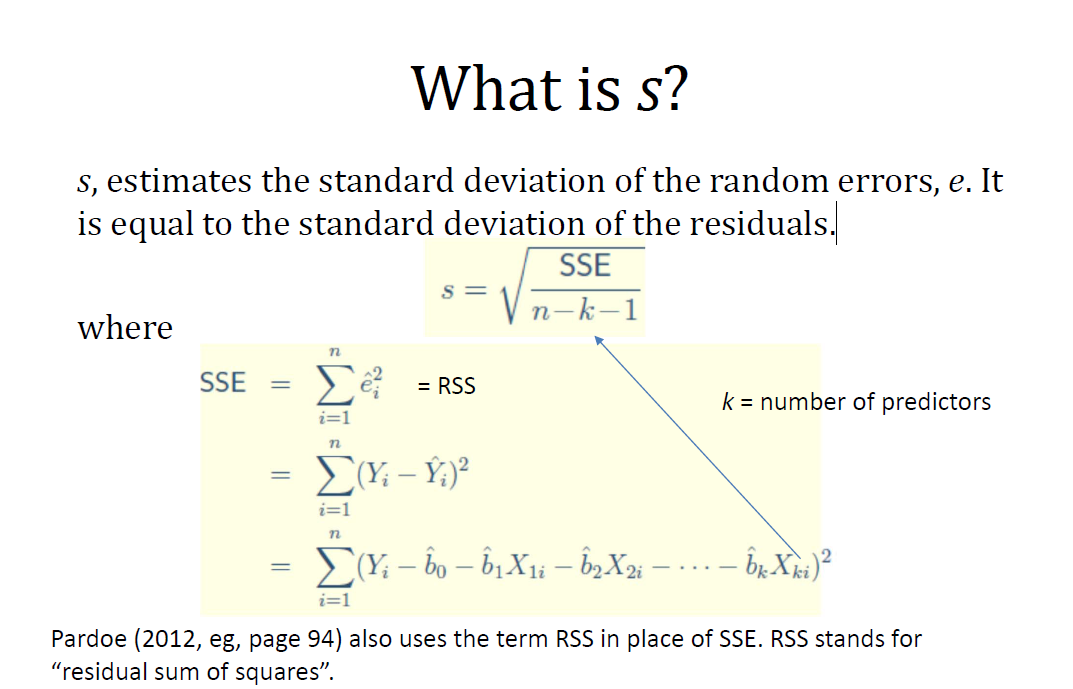

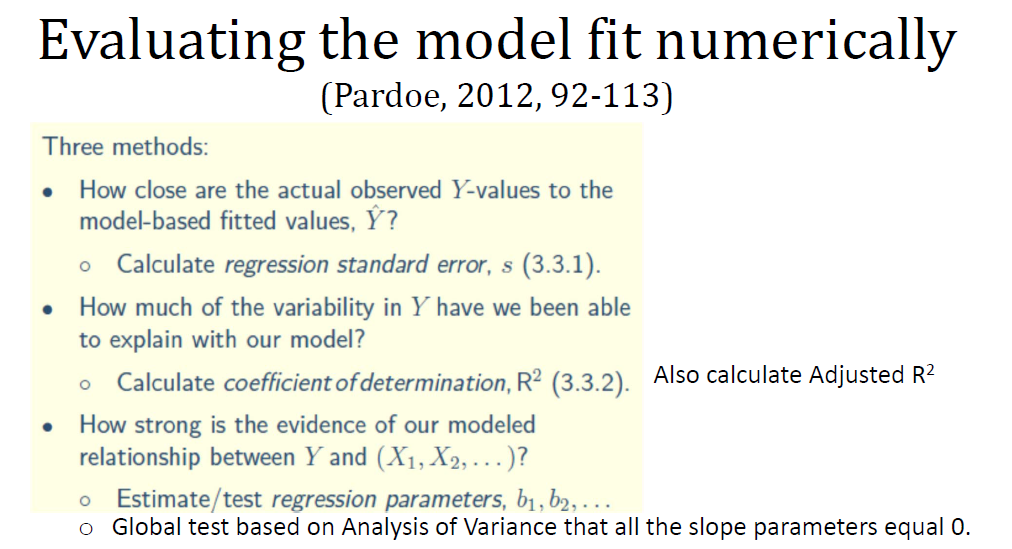

What happens if all the slope parameters are zero? Then y is a constant and all your predictors are garbage! In big data that is usually not a problem. However, if you have smaller data, it's very important. 

# Adjusted R^2

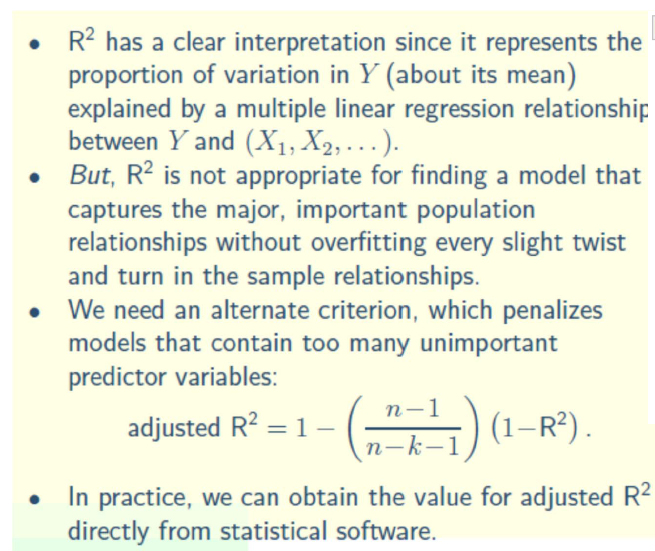

Analysis of variance (ANOVA) is a collection of statistical models and their associated estimation procedures (such as the "variation" among and between groups) used to analyze the differences among group means in a sample. ANOVA was developed by the statistician <b>Ronald Fisher.</b> The ANOVA is based on the law of total variance, where the observed variance in a particular variable is partitioned into components attributable to different sources of variation. In its simplest form, ANOVA provides a statistical test of whether two or more population means are equal, and therefore generalizes the t-test beyond two means.

# Global Test: Analysis of Variance (ANOVA)

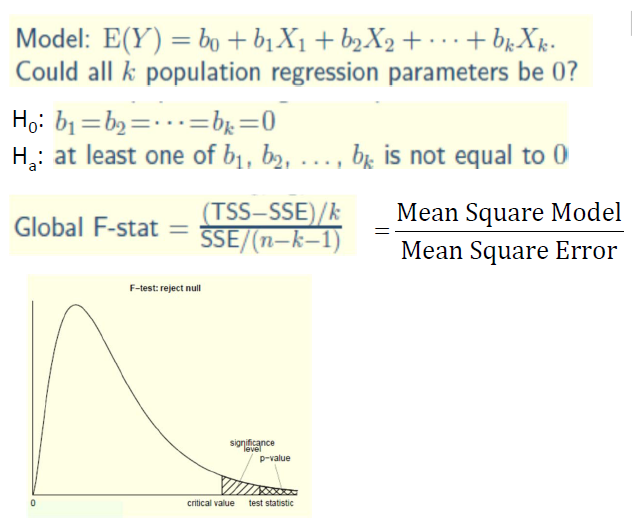

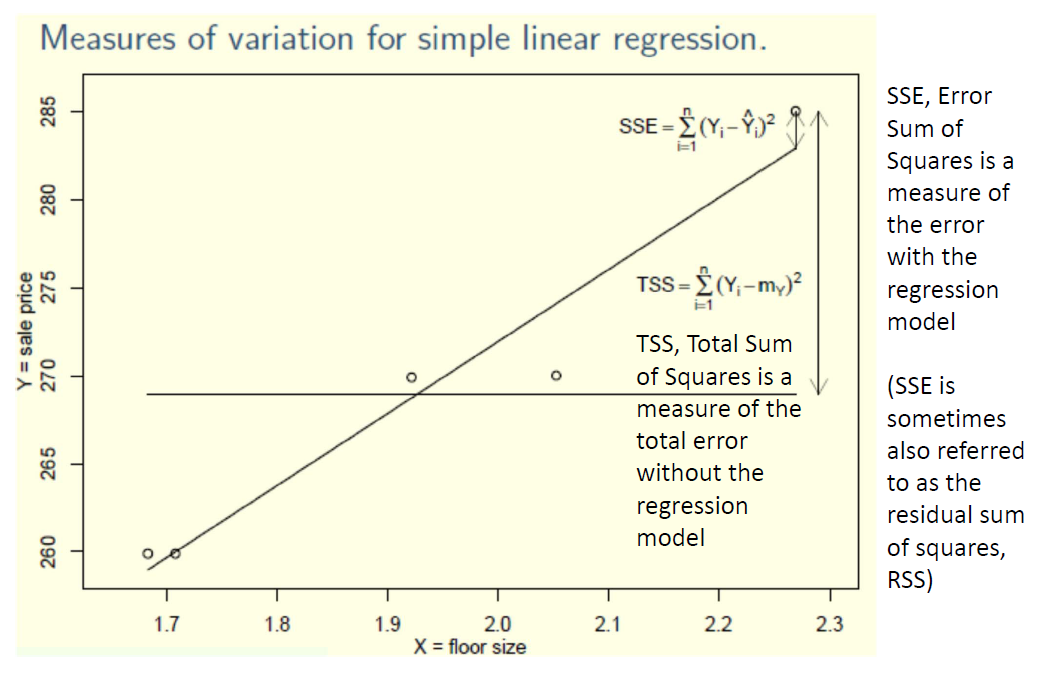

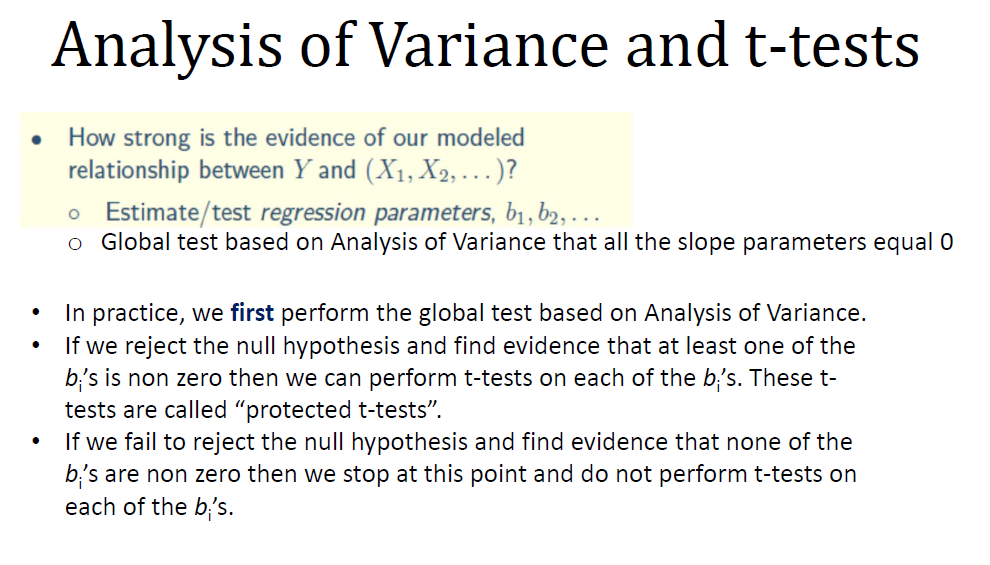

# Let's look at the data again.  Which one of these rows is not like the other?

In [102]:
data.head(20)

Movie Title  \
0   Star Wars: Episode VII - The Force Awakens   
1                               Jurassic World   
2                      Avengers: Age of Ultron   
3                                   Inside Out   
4                                    Furious 7   
5                                      Minions   
6        The Hunger Games: Mockingjay - Part 2   
7                                  The Martian   
8                                   Cinderella   
9                                      Spectre   
10          Mission: Impossible - Rogue Nation   
11                             Pitch Perfect 2   
12                                The Revenant   
13                                     Ant-Man   
14                                        Home   
15                        Hotel Transylvania 2   
16                        Fifty Shades of Grey   
17    The SpongeBob Movie: Sponge Out of Water   
18                      Straight Outta Compton   
19                                 San Andreas   

                                 Studio  Total Gross  Widest Release  \
0   Walt Disney Studios Motion Pictures    936662225            4134   
1                    Universal Pictures    652270625            4291   
2   Walt Disney Studios Motion Pictures    459005868            4276   
3   Walt Disney Studios Motion Pictures    356461711            4158   
4                    Universal Pictures    353007020            4022   
5                    Universal Pictures    336045770            4311   
6                             Lionsgate    281723902            4175   
7                 Twentieth Century Fox    228433663            3854   
8   Walt Disney Studios Motion Pictures    201151353            3848   
9     Sony Pictures Entertainment (SPE)    200074609            3929   
10                   Paramount Pictures    195042377            3988   
11                   Universal Pictures    184296230            3660   
12                Twentieth Century Fox    183637894            3711   
13  Walt Disney Studios Motion Pictures    180202163            3868   
14                Twentieth Century Fox    177397510            3801   
15    Sony Pictures Entertainment (SPE)    169700110            3768   
16                   Universal Pictures    166167230            3655   
17                   Paramount Pictures    162994032            3680   
18                   Universal Pictures    161197785            3142   
19                         Warner Bros.    155190832            3812   

    Opening Gross  Opening Theaters  Days In Release  
0       247966675              4134              380  
1       208806270              4274              210  
2       191271109              4276              245  
3        90440272              3946              203  
4       147187040              4004              273  
5       115718405              4301              182  
6       102665981              4175              408  
7        54308575              3831              457  
8        67877361              3845              294  
9        70403148              3929              422  
10       55520089              3956              154  
11       69216890              3473              231  
12         474560                 4              373  
13       57225526              3856              175  
14       52107731              3708              280  
15       48464322              3754              464  
16       85171450              3646              322  
17       55365012              3641              329  
18       60200180              2757              140  
19       54588173              3777              217

# Answer

Opening Gross is much lower than expected for some films due to “a limited opening release”. The Revenant is a limitted release. 

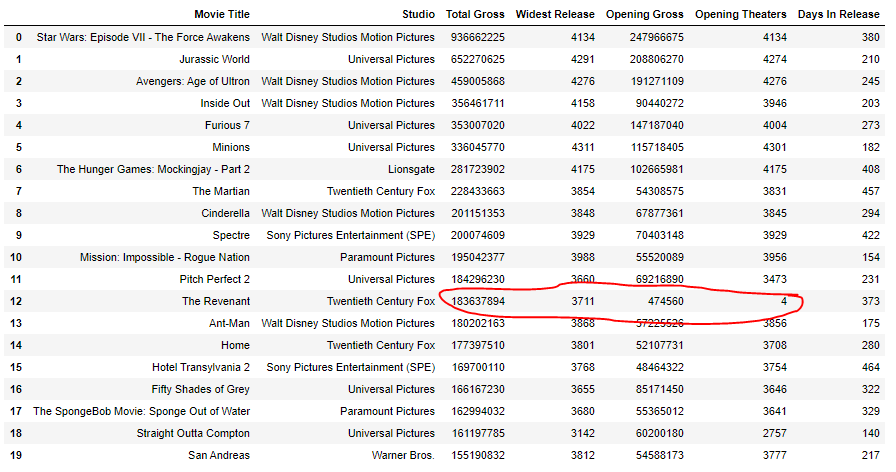

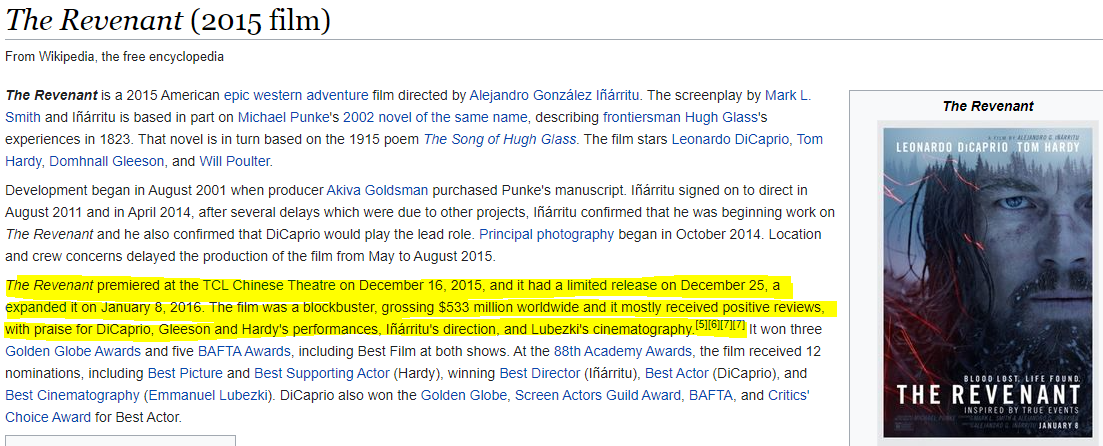

## From the scatterplot, we noticed this pattern......

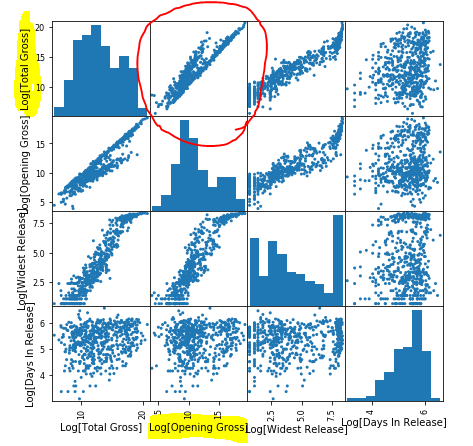

## Let's plot the relationship

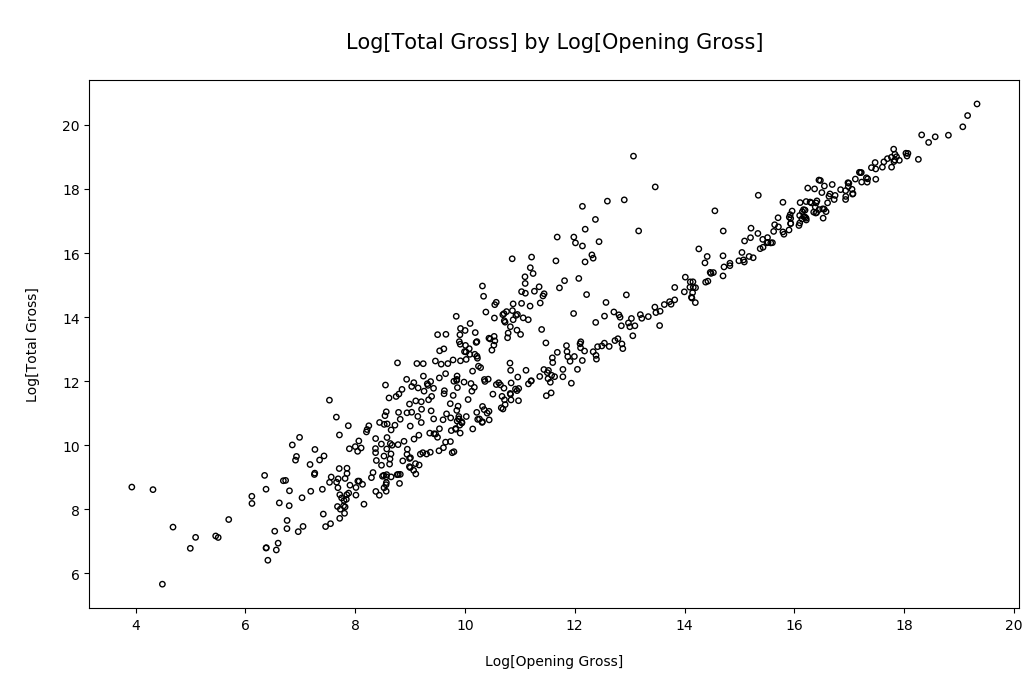

In [103]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (12,7), dpi = 100)

# max_limits = max(max(df['Log[Total Gross]']),max(df['Log[Total Gross] Predicted']))*1.10
# min_limits = min(min(df['Log[Total Gross]']),min(df['Log[Total Gross] Predicted']))*1.10
# prediction_line = [min_limits, max_limits]
        
ax.set_title('\nLog[Total Gross] by Log[Opening Gross]\n', fontsize = 15)
ax.set_xlabel('\nLog[Opening Gross]\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross]\n', fontsize = 10)
ax.scatter(df['Log[Opening Gross]'], df['Log[Total Gross]'], facecolors='none', edgecolors='black', linewidth = 1, s = 15)

plt.show()

There appear to be two clusters of points in the plot above. Can you see the pattern?

Next, we create a new column or variable called Opening Fraction which is the ratio of
Opening Theaters to Widest Release

### Plot the relationship using df['Opening Fraction']

In [104]:
data['Opening Fraction'] = data['Opening Theaters']/data['Widest Release']


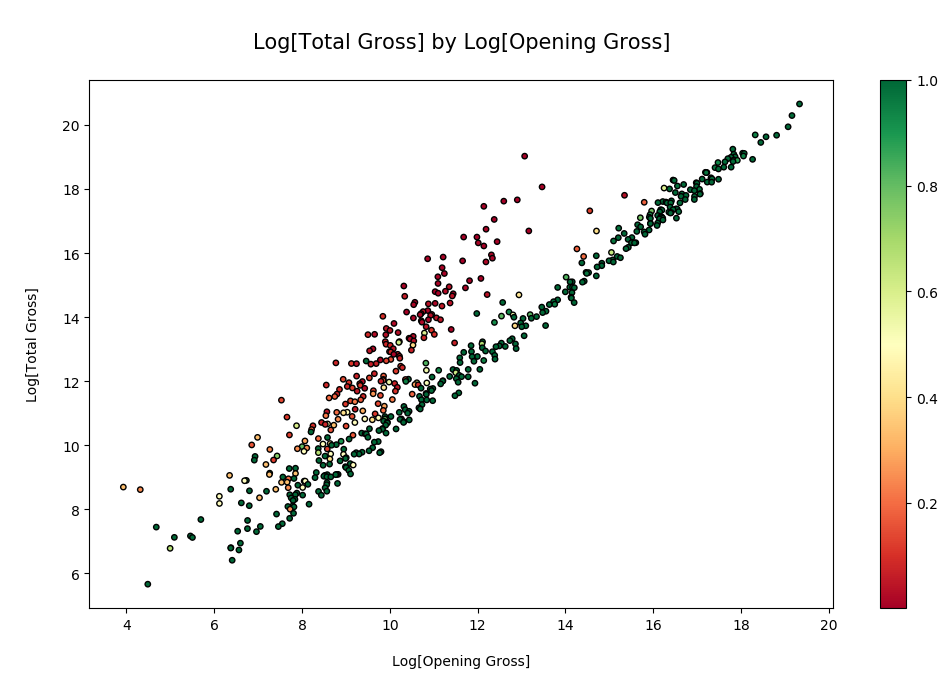

In [105]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (12,7), dpi = 100)
      
ax.set_title('\nLog[Total Gross] by Log[Opening Gross]\n', fontsize = 15)
ax.set_xlabel('\nLog[Opening Gross]\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross]\n', fontsize = 10)

sc = ax.scatter(df['Log[Opening Gross]'], df['Log[Total Gross]'], facecolors='none', edgecolors='black', c= data['Opening Fraction'], cmap="RdYlGn", linewidth = 1, s = 15)

plt.colorbar(sc)
plt.show()

In [107]:
color_filter = data['Opening Fraction']
df['Opening Fraction'] = color_filter

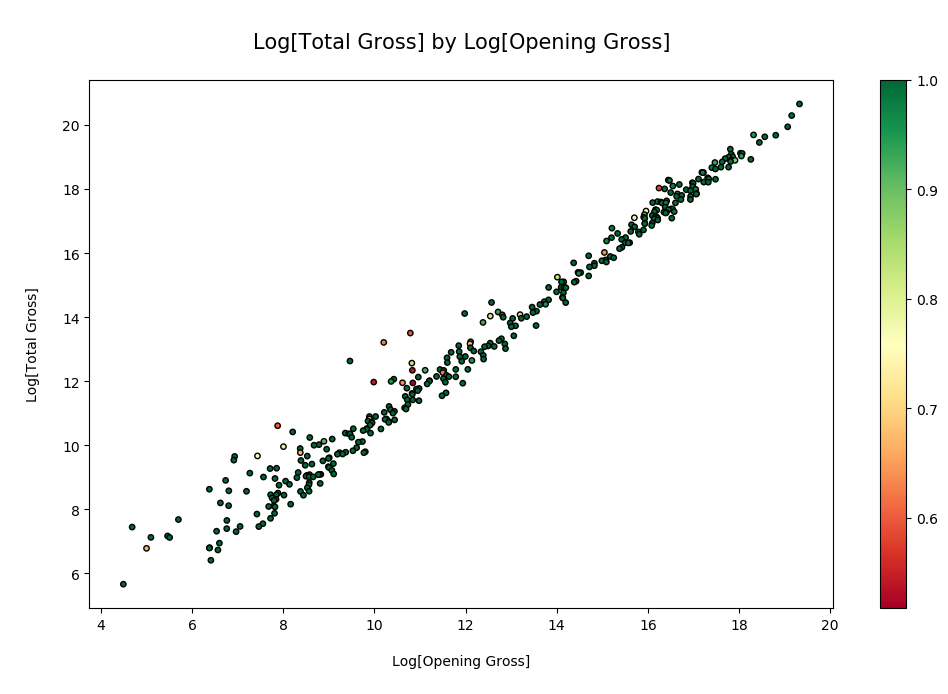

In [110]:

dfa = df.loc[df['Opening Fraction']>0.5].copy()

plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (12,7), dpi = 100)
      
ax.set_title('\nLog[Total Gross] by Log[Opening Gross]\n', fontsize = 15)
ax.set_xlabel('\nLog[Opening Gross]\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross]\n', fontsize = 10)

sc = ax.scatter(dfa['Log[Opening Gross]'], dfa['Log[Total Gross]'], facecolors='none', edgecolors='black', c= dfa['Opening Fraction'], cmap="RdYlGn", linewidth = 1, s = 15)

plt.colorbar(sc)
plt.show()

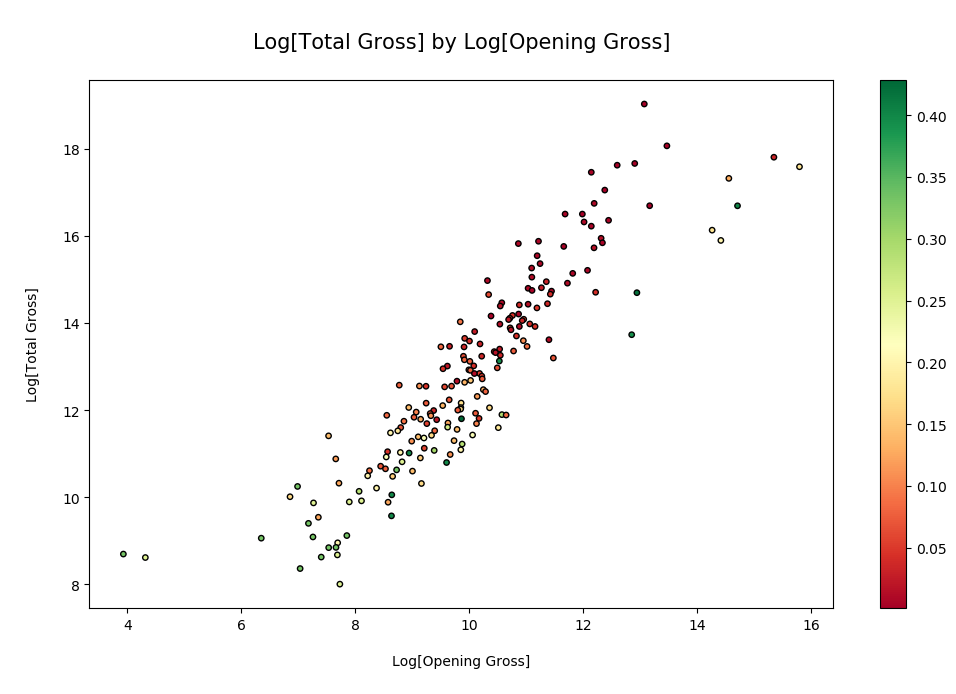

In [111]:
dfa = df.loc[df['Opening Fraction']<0.5].copy()

plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (12,7), dpi = 100)
      
ax.set_title('\nLog[Total Gross] by Log[Opening Gross]\n', fontsize = 15)
ax.set_xlabel('\nLog[Opening Gross]\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross]\n', fontsize = 10)

sc = ax.scatter(dfa['Log[Opening Gross]'], dfa['Log[Total Gross]'], facecolors='none', edgecolors='black', c= dfa['Opening Fraction'], cmap="RdYlGn", linewidth = 1, s = 15)

plt.colorbar(sc)
plt.show()

### Conclusion: 
The relationship between Opening gross and Total gross appears to be different depending on whether OpeningFraction is < 0.5 or not.



### How to address this relationship?

Thus, we shall create a new variable called <b>LimitedRelease</b> which is <b>1</b> if <b>OpeningFraction < 0.5</b> and <b>0 if OpeningFraction ≥ 0.5</b>

In [135]:
# create the column
data['Limited Release'] = np.where(data['Opening Fraction'] < 0.5, 1, 0)
                                 

In [136]:
# display the results
display(data.loc[data['Opening Fraction']>=0.5])
display(data.loc[data['Opening Fraction']<0.5])

Movie Title  \
0    Star Wars: Episode VII - The Force Awakens   
1                                Jurassic World   
2                       Avengers: Age of Ultron   
3                                    Inside Out   
4                                     Furious 7   
..                                          ...   
655                       Le talent de mes amis   
656                                   Big Muddy   
657                         [REC] 4: Apocalypse   
658                             United Passions   
660                                        Lou!   

                                  Studio  Total Gross  Widest Release  \
0    Walt Disney Studios Motion Pictures    936662225            4134   
1                     Universal Pictures    652270625            4291   
2    Walt Disney Studios Motion Pictures    459005868            4276   
3    Walt Disney Studios Motion Pictures    356461711            4158   
4                     Universal Pictures    353007020            4022   
..                                   ...          ...             ...   
655                        Distrib Films          889               1   
656                       Monterey Media          881               3   
657                    Magnolia Pictures          837               5   
658                   Screen Media Films          607              10   
660                        Distrib Films          287               1   

     Opening Gross  Opening Theaters  Days In Release  Opening Fraction  \
0        247966675              4134              380          1.000000   
1        208806270              4274              210          0.996038   
2        191271109              4276              245          1.000000   
3         90440272              3946              203          0.949014   
4        147187040              4004              273          0.995525   
..             ...               ...              ...               ...   
655            587                 1               28          1.000000   
656            147                 2              343          0.666667   
657            708                 5              364          1.000000   
658            607                10              210          1.000000   
660             88                 1              252          1.000000   

     Limited Release  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
..               ...  
655                0  
656                0  
657                0  
658                0  
660                0  

[368 rows x 9 columns]

Movie Title                 Studio  Total Gross  \
12            The Revenant  Twentieth Century Fox    183637894   
43           The Big Short     Paramount Pictures     70259870   
53       The Hateful Eight  The Weinstein Company     54117416   
59                 Sicario              Lionsgate     46889293   
61               Spotlight   Open Road Films (II)     45055776   
..                     ...                    ...          ...   
590               Top Spin              First Run         5858   
597      Our Man in Tehran              First Run         5573   
598             The Living         Monterey Media         5514   
617  Set Fire to the Stars       Strand Releasing         4280   
633                  Moana            Kino Lorber         2993   

     Widest Release  Opening Gross  Opening Theaters  Days In Release  \
12             3711         474560                 4              373   
43             2529         705527                 8              387   
53             2938        4610676               100              373   
59             2620         401288                 6              471   
61             1227         295009                 5              422   
..              ...            ...               ...              ...   
590               4           2177                 1              140   
597               3           1640                 1              231   
598               4             74                 1              273   
617               3           1132                 1              203   
633               4           2274                 1              415   

     Opening Fraction  Limited Release  
12           0.001078                1  
43           0.003163                1  
53           0.034037                1  
59           0.002290                1  
61           0.004075                1  
..                ...              ...  
590          0.250000                1  
597          0.333333                1  
598          0.250000                1  
617          0.333333                1  
633          0.250000                1  

[192 rows x 9 columns]

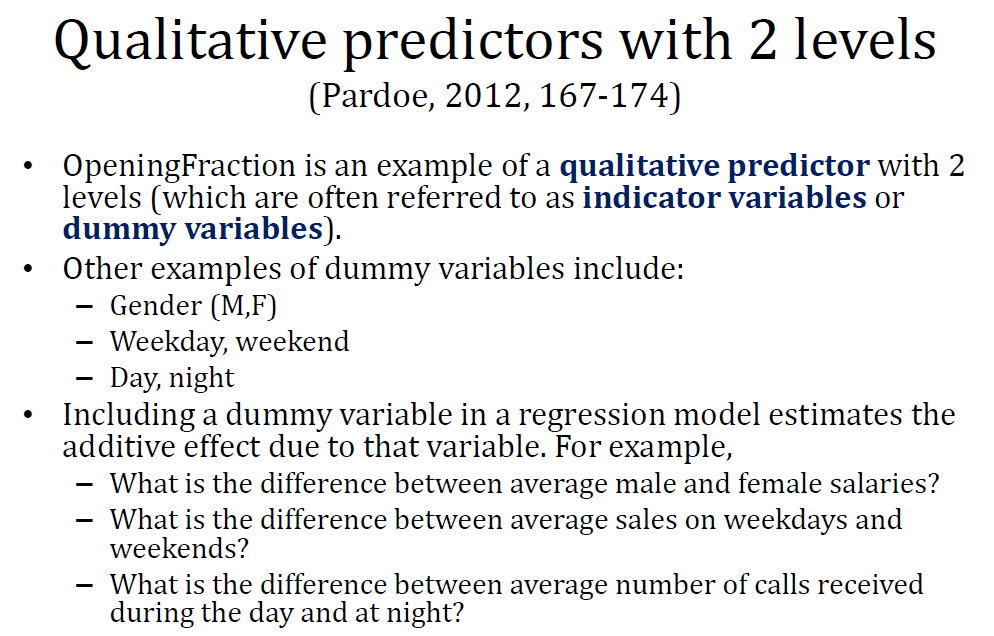

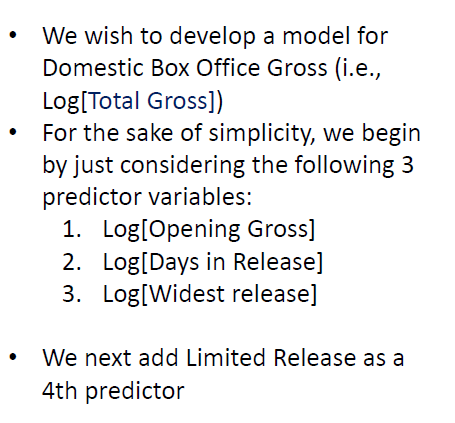

The relationship between
Opening gross and Total gross
appears to be different
depending on whether
Limited Release is 0 or 1. In
particular, the slope of the
line of best fit appears to be a
little steeper if Limited
Release = 1. Thus, we need to
fit a model which allows for
these slopes to be different.

# NOTE for AJ!!!! We will cover multicollinearity next class... 

# Interactions 

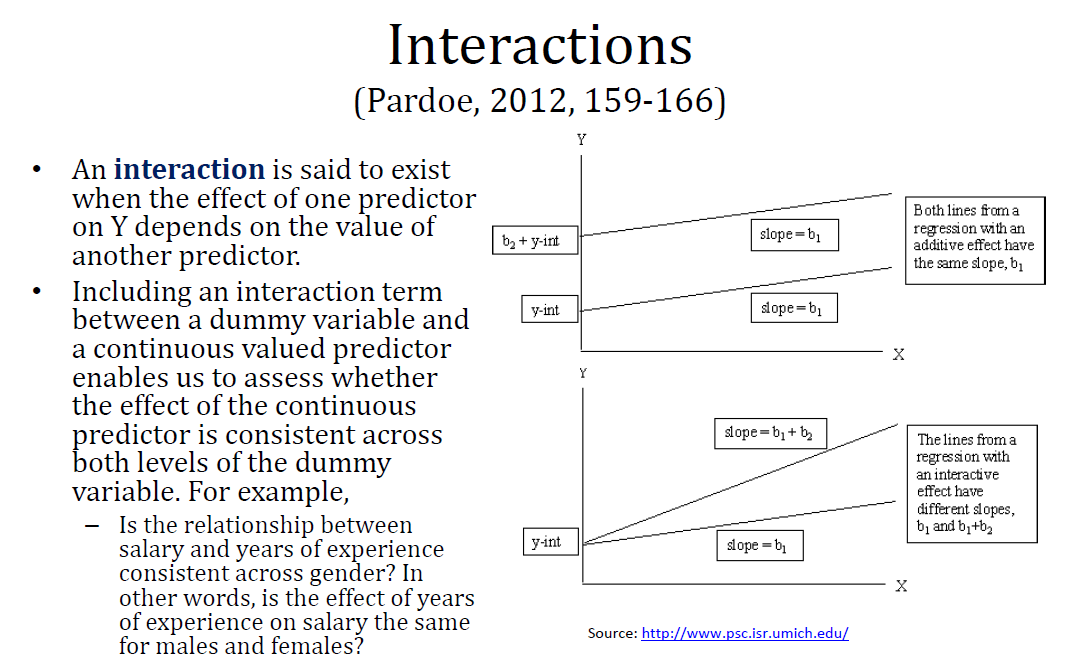

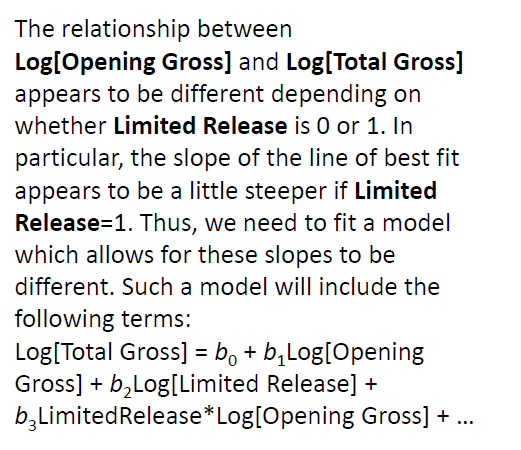

The term <b>Limited Release*Log[Opening Gross]</b> is called an <b>interaction term</b>, which
allows us to fit a different effect due to Log[Opening Gross] when <b>Limited Release=1</b>.

### Add Limited Release to the Modeling Data

In [138]:
df['Limited Release'] = data['Limited Release']

### Add the Interaction Term Limited Release*Log[Opening Gross] 

In [139]:
df['Limited Release*Log[Opening Gross]'] = df['Limited Release']*df['Log[Opening Gross]']
df.head()

Total Gross  Opening Gross  Widest Release  Days In Release  \
0    936662225      247966675            4134              380   
1    652270625      208806270            4291              210   
2    459005868      191271109            4276              245   
3    356461711       90440272            4158              203   
4    353007020      147187040            4022              273   

   Log[Total Gross]  Log[Opening Gross]  Log[Widest Release]  \
0         20.657833           19.328805             8.327243   
1         20.295970           19.156917             8.364508   
2         19.944574           19.069202             8.361007   
3         19.691737           18.320200             8.333030   
4         19.681999           18.807215             8.299783   

   Log[Days In Release]  Log[Total Gross] Predicted  residuals  \
0              5.942799                   19.834068   0.823765   
1              5.351858                   19.580661   0.715309   
2              5.505332                   19.554263   0.390311   
3              5.318120                   18.962069   0.729668   
4              5.613128                   19.369673   0.312325   

   studentized_residuals  cooks_distance  Opening Fraction  Limited Release  \
0               1.297061        0.006618          1.000000                0   
1               1.124542        0.004371          0.996038                0   
2               0.612855        0.001235          1.000000                0   
3               1.144029        0.003072          0.949014                0   
4               0.489973        0.000715          0.995525                0   

   Limited Release*Log[Opening Gross]  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0

In [140]:
#  New Model
y = df['Log[Total Gross]']
X = df[['Log[Opening Gross]','Log[Widest Release]','Log[Days In Release]','Limited Release','Limited Release*Log[Opening Gross]']]
X = sm.add_constant(X)

ols_model = sm.OLS(y, X)
fitted = ols_model.fit()

df['Log[Total Gross] Predicted'] = fitted.predict(X)

df['residuals'] = df['Log[Total Gross]'] - df['Log[Total Gross] Predicted'] # residuals
influence                   = fitted.get_influence()                        # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external          # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                   # cook's distance

summary = fitted.summary() 
print(summary)


                            OLS Regression Results                            
Dep. Variable:       Log[Total Gross]   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2866.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:50:21   Log-Likelihood:                -538.79
No. Observations:                 560   AIC:                             1090.
Df Residuals:                     554   BIC:                             1116.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### Remove the statistically insignificant terms and make a more parsimonious model

In [141]:
#  New Model
y = df['Log[Total Gross]']
X = df[['Log[Opening Gross]','Log[Widest Release]','Log[Days In Release]','Limited Release*Log[Opening Gross]']]
X = sm.add_constant(X)

ols_model = sm.OLS(y, X)
fitted = ols_model.fit()

df['Log[Total Gross] Predicted'] = fitted.predict(X)

df['residuals'] = df['Log[Total Gross]'] - df['Log[Total Gross] Predicted'] # residuals
influence                   = fitted.get_influence()                        # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external          # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                   # cook's distance

summary = fitted.summary() 
print(summary)

                            OLS Regression Results                            
Dep. Variable:       Log[Total Gross]   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3573.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:50:32   Log-Likelihood:                -539.98
No. Observations:                 560   AIC:                             1090.
Df Residuals:                     555   BIC:                             1112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

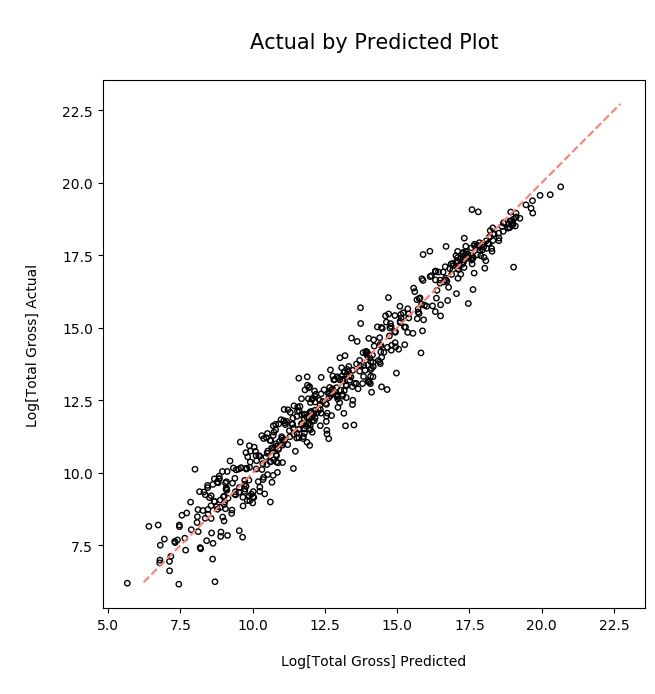

In [142]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (7,7), dpi = 100)

max_limits = max(max(df['Log[Total Gross]']),max(df['Log[Total Gross] Predicted']))*1.10
min_limits = min(min(df['Log[Total Gross]']),min(df['Log[Total Gross] Predicted']))*1.10
prediction_line = [min_limits, max_limits]
        
ax.set_title('\nActual by Predicted Plot\n', fontsize = 15)
ax.set_xlabel('\nLog[Total Gross] Predicted\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross] Actual\n', fontsize = 10)
ax.scatter(df['Log[Total Gross]'], df['Log[Total Gross] Predicted'], facecolors='none', edgecolors='black', linewidth = 1, s = 15)
ax.plot(prediction_line,prediction_line, color = 'salmon', linestyle = '--', label = 'Prediction Line')
plt.show()

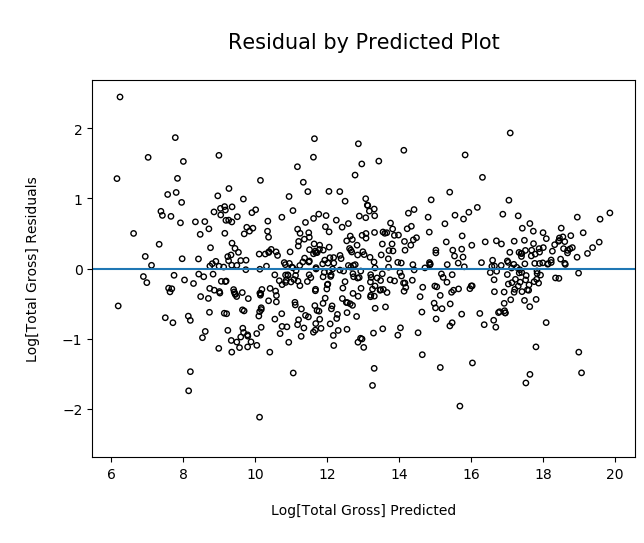

In [143]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)

max_limits = max(abs(min(df['residuals'])),abs(max(df['residuals'])))*1.10
        
ax.set_title('\nResidual by Predicted Plot\n', fontsize = 15)
ax.set_xlabel('\nLog[Total Gross] Predicted\n', fontsize = 10)
ax.set_ylabel('\nLog[Total Gross] Residuals\n', fontsize = 10)
ax.scatter(df['Log[Total Gross] Predicted'], df['residuals'], facecolors='none', edgecolors='black', linewidth = 1, s = 15)
ax.set_ylim(-max_limits, max_limits)
ax.axhline(y=0)
plt.show()

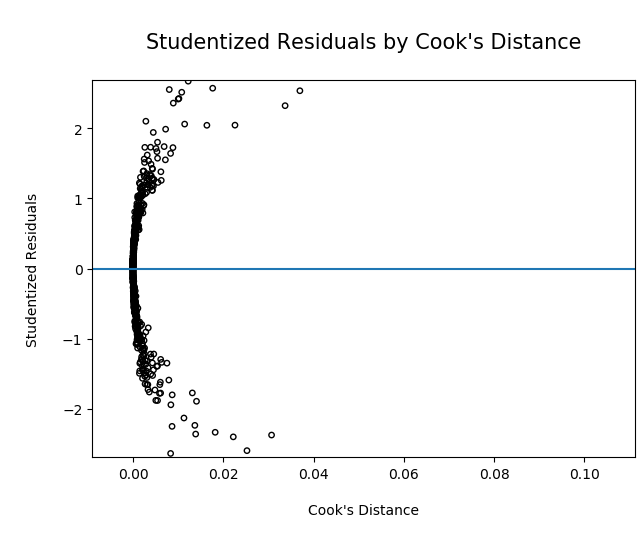

In [144]:
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)

max_limits = max(abs(min(df['residuals'])),abs(max(df['residuals'])))*1.10
        
ax.set_title("\nStudentized Residuals by Cook's Distance\n", fontsize = 15)
ax.set_xlabel("\nCook's Distance\n", fontsize = 10)
ax.set_ylabel('\nStudentized Residuals\n', fontsize = 10)
ax.scatter(df['cooks_distance'], df['studentized_residuals'], facecolors='none', edgecolors='black', linewidth = 1, s = 15)
ax.set_ylim(-max_limits, max_limits)
ax.axhline(y=0)
plt.show()

# Interpreting the Model

In [145]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:       Log[Total Gross]   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3573.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:50:32   Log-Likelihood:                -539.98
No. Observations:                 560   AIC:                             1090.
Df Residuals:                     555   BIC:                             1112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## Base Model (Plug and Chug)

- The interaction term between Limited Release and Log[Opening Gross] is highly statistically significant (p‐value < 0.0001).
- The estimated regression model includes the following terms:


<p>
<b>Log[Total Gross]</b> = (1.3262)+(0.8534)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>‐(0.1386)<b>LimitedRelease*Log[Opening Gross]</b>
</p>

In [146]:
(-0.1386)(1)*Log[Opening Gross] + (0.8534)Log[Opening Gross] 

SyntaxError: invalid syntax (<ipython-input-146-0d7d1617b904>, line 1)

## When Limited Release = 1
<p>
<b>Log[Total Gross]</b> = (1.3262)+(0.8534)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>‐(0.1386)<b>(1)*Log[Opening Gross]</b>
</p>
<p>
SIMPLIFY:
</p>
<p>
<b>Log[Total Gross]</b> = (1.3262)+(0.7148)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>   
</p>

## When Limited Release = 0

In [ ]:
Log[Total Gross] = (1.3262)+(0.8534)Log[Opening Gross]+(0.3883)Log[Widest Release]+(0.2454)Log[Days In Release]

<p>
<b>Log[Total Gross]</b> = (1.3262)+(0.8534)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>‐(0.1386)<b>(0)*Log[Opening Gross]</b>
</p>
<p>
SIMPLIFY:
</p>
<p>
<b>Log[Total Gross]</b> = (1.3262)+(0.8534)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>
</p>

# CONCLUSION:  
When Limited Release is 0, there is a steeper slope to the line<b>Log[Opening Gross]</b>. The term for that is called an "Interacting Effect"

# Interpreting the model based on logarithms

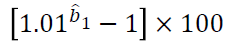

In [124]:
def interpret(coeff):
    percentage_change = 100*((1.01**coeff)-1)
    return round(percentage_change,2)

## When Limited Release = 1

<b>Log[Total Gross]</b> = (1.3262)+(0.7148)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>   
</p>

In [131]:
b1 = interpret(0.7148)
b2 = interpret(0.3883)
b3 = interpret(0.2454)


print('1% change for b1 = {}% in y'.format(b1))
print('1% change for b2 = {}% in y'.format(b2))
print('1% change for b3 = {}% in y'.format(b3))

1% change for b1 = 0.71% in y
1% change for b2 = 0.39% in y
1% change for b3 = 0.24% in y


For this model we have the following model effects based on these coeffiecients:
- b1 = (0.7148) - a 1% increase in Opening Gross is predicted to produce a change in Total Gross of 0.71%
- b2 = (0.3883) - a 1% increase in Widest Release is predicted to produce a change in Total Gross of 0.39%
- b3 = (0.2454) - a 1% increase in Days in Release is predicted to produce a change in Total Gross of 0.24%

## When Limited Release = 0

<p>
<b>Log[Total Gross]</b> = (1.3262)+(0.8534)<b>Log[Opening Gross]</b>+(0.3883)<b>Log[Widest Release]</b>+(0.2454)<b>Log[Days In Release]</b>
</p>

In [132]:
b1 = interpret(0.8534)
b2 = interpret(0.3883)
b3 = interpret(0.2454)

print('% change for b1 = {}%'.format(b1))
print('% change for b2 = {}%'.format(b2))
print('% change for b3 = {}%'.format(b3))

% change for b1 = 0.85%
% change for b2 = 0.39%
% change for b3 = 0.24%


For this model we have the following model effects based on these coeffiecients:
- <b>b1 = (0.8534) - a 1% increase in Opening Gross is predicted to produce a change in Total Gross of 0.85%</b>
- b2 = (0.3883) - a 1% increase in Widest Release is predicted to produce a change in Total Gross of 0.39%
- b3 = (0.2454) - a 1% increase in Days in Release is predicted to produce a change in Total Gross of 0.24%

# Example:  The Revenant...It was a very popular film. If it does really well in a small number of theaters, the multiplying affect is much higher when it's released to a much larger number of theaters. 